<a target="_blank" href="https://colab.research.google.com/github/sonder-art/automl_o23/blob/main/codigo/nlp_chatbots/twitter_generation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Instalacion de librerias

In [1]:
!pip install transformers datasets
!pip install accelerate -U
!pip install transformers[torch] -U

# Importar Librerias

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datasets import load_dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
import torch

# Revisar device (Cuda)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Login a Huggingface

Asegurate de generar un token usando la `url` proporcionada por el login, y que este toquen sea de `write` y no solo escritura para que podamos salvar nuestro modelo.

In [6]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-c

# ETL

In [7]:
# Load SST-2 dataset from the Hugging Face datasets library
dataset = load_dataset("BrunoGR/Twitter_Sentiment_Analysis_Train_Corpus_in_Spanish")

In [8]:
# # Convert the train dataset to pandas DataFrame for EDA
# train_df = pd.DataFrame(dataset['train'])
# train_df.head()

In [9]:
# Convert the test dataset to pandas DataFrame for EDA
test_df = pd.DataFrame(dataset['test'])
test_df.head()

,etiqueta,texto
0,Sentimiento: Negativo,Consulta: < ADIÓS 36th ST Planta de estampado:...
1,Sentimiento: Negativo,"Consulta: < @USUARIO no, todavía estoy aquí......"
2,Sentimiento: Negativo,Consulta: < dsfgdehrgb esta noche! Aunque quie...
3,Sentimiento: Positivo,"Consulta: < @USER Show salió ayer señor, lo es..."
4,Sentimiento: Positivo,Consulta: < #the hangover... lo vi el lunes po...


Podemos observar que los tweets tienen prefijos que pueden alterar la generacion de tweets, asi que hay que modificarlos

In [11]:
test_df['texto'].values[6]

'Consulta: < @USUARIO ¡Ajá! así es>\n'

Podemos limpiarlos usando regular expressions!

In [12]:
import re
# Sample text
text = "Consulta: < @USUARIO ¡Ajá! así es>\n"
# Regex pattern to match text within angle brackets
pattern = r"<(.*?)>"
# Find matches in the sample text
matches = re.findall(pattern, text)
# Extract the sentences without the angle brackets and 'Consulta: ' part
cleaned_sentences = [match.strip() for match in matches]
print(cleaned_sentences)


['@USUARIO ¡Ajá! así es']


In [13]:
pattern = r"<(.*?)>"
# Apply the regex pattern to the column and create a new column with the extracted text
test_df['texto'] = test_df['texto'].str.extract(pattern, expand=False).str.strip()
print(test_df['texto'])

0         ADIÓS 36th ST Planta de estampado: USTEDES SON...
1         @USUARIO no, todavía estoy aquí... la última n...
2          dsfgdehrgb esta noche! Aunque quiero a Amy allí.
3         @USER Show salió ayer señor, lo estamos hacien...
4         #the hangover... lo vi el lunes por la noche. ...
                                ...                        
334636    Tan jodidamente enfermo. no puedo volver a dormir
334637                         @USUARIO estoy leyendo un ff
334638    @USUARIO DESEOHHHH!! lástima que tengo escuela...
334639    Estoy emocionado como un niño pequeño... ¡Se e...
334640    Booo hoooooo Waaaaaaaaaaaaaaaa MIS AURICULARES...
Name: texto, Length: 334641, dtype: object


# Importar Modelo y Tokenizer

In [30]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', padding="max_length",
                                 truncation=True, max_length=280)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'  # Explicitly set padding to the left

model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
#model = AutoModelForCausalLM.from_pretrained("uumami/twitter_automl_023")

Veamos como se comporta el modelo antes de entrenar

In [ ]:
# Encode some text to get the input ids
prompt_text = "Me, molesta"
input_ids = tokenizer.encode(prompt_text, return_tensors='pt')

# Generate text sequences
outputs = model.generate(
    input_ids,
    max_length=100,
    num_return_sequences=1,
    no_repeat_ngram_size=2,
    early_stopping=True
)

# Decode the generated sequences to text
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(generated_text)

In [60]:
from datasets import Dataset
def tokenize_and_prepare_labels(examples):
    # Tokenize the inputs and labels
    tokenized_inputs = tokenizer(examples["texto"], padding="max_length",
                                 truncation=True, max_length=280)

    # Our inputs are the tokenized inputs
    inputs = tokenized_inputs.input_ids

    # The labels are the input IDs shifted to the left (to predict the next token)
    labels = tokenized_inputs.input_ids.copy()

    # We need to replace the padding token id's of the labels by -100 so that
    # they are not taken into account by the Cross Entropy Loss
    labels = [[(label if label != tokenizer.pad_token_id else -100)
     for label in labels_example] for labels_example in labels]

    # Return the prepared dictionary
    # Including the labels and input_ids for the model to work
    return {'input_ids': inputs, 'labels': labels}

# Map the dataset to the function
tokenized_datasets =  Dataset.from_pandas(test_df.loc[range(15000,20000)]).map(
    tokenize_and_prepare_labels, batched=True)


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [61]:
len(tokenized_datasets['input_ids'])

5000

In [62]:
len(tokenized_datasets['input_ids'][1])

280

In [63]:
tokenized_datasets['labels'][1]

[-100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,

In [64]:
tokenized_datasets['input_ids'][1]

[50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,
 50256,


# Entrenamiento

In [65]:
# Define your training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=12,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Initialize the Trainer
trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=tokenized_datasets,
)

# Train the model
trainer.train()

Step,Training Loss


TrainOutput(global_step=417, training_loss=4.2094035708932855, metrics={'train_runtime': 399.4045, 'train_samples_per_second': 12.519, 'train_steps_per_second': 1.044, 'total_flos': 714470400000000.0, 'train_loss': 4.2094035708932855, 'epoch': 1.0})

In [83]:
# Encoding the input text
input_text = "Me molesta "

# encoding =  tokenizer.encode_plus(input_text, return_tensors='pt')
# input_ids = encoding['input_ids'].to(device)
# attention_mask = encoding['attention_mask'].to(device)

input_ids = tokenizer.encode(input_text, return_tensors='pt',
                             truncation=True)

# Generate a sequence of text
output_sequences = model.generate(
    input_ids=input_ids.to(device),
    #attention_mask=attention_mask,
    max_length=280,  # You can change the length as needed
    temperature=1.0,  # Controls the randomness of the generation
    num_return_sequences=1,
    pad_token_id=tokenizer.eos_token_id  # Set the pad token id to the eos_token_id
)

# Decode the output
generated_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
print(generated_text)


Me molesta!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 


# Guardar Modelo en cuenta


In [31]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

Antes de guardar tu modelo, asegura de crear un repositorio en huggingface para guardar tu modelo.  
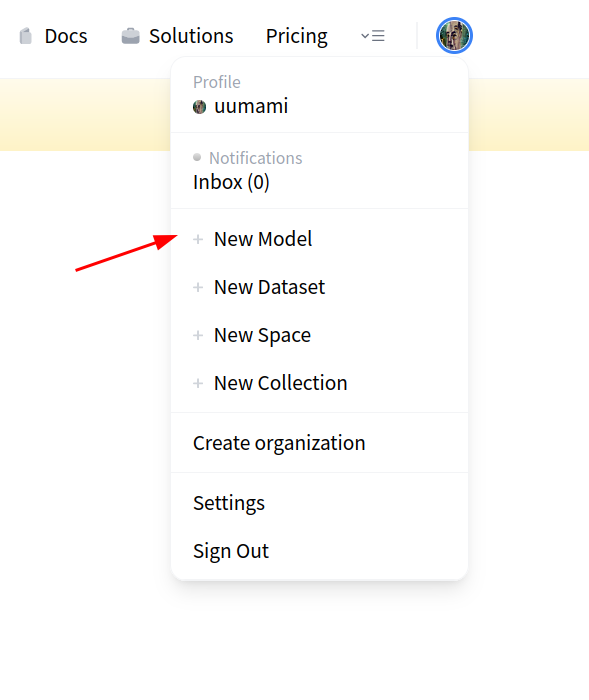

Revisa que version del modelo deseas guardar, la recomendacion es que sea el ultimo checkpoint

In [58]:
! ls results

checkpoint-1000  checkpoint-2000  checkpoint-3000  checkpoint-4000  checkpoint-500
checkpoint-1500  checkpoint-2500  checkpoint-3500  checkpoint-4500  checkpoint-5000


In [37]:
from huggingface_hub import HfApi
api = HfApi()

# Modificalo para que sea tu repositorio
api.upload_folder(
    folder_path="results/checkpoint-5000", # Modelo a guardar
    repo_id="uumami/twitter_automl_023", # Repositorio
    repo_type="model", # Tipo de repositorio, en nuestro caso modelo
    path_in_repo="checkpoint-5000", # Carpeta para guardar el modelo
)

'https://huggingface.co/uumami/twitter_automl_023/tree/main/checkpoint-5000'

# Cargar Modelo guardado

In [79]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer2 = GPT2Tokenizer.from_pretrained('gpt2', padding="max_length",
            truncation=True, max_length=280)
tokenizer2.pad_token = tokenizer2.eos_token
tokenizer2.padding_side = 'left'  # Explicitly set padding to the left
model2 = AutoModelForCausalLM.from_pretrained("uumami/twitter_automl_023")

In [84]:
# Encoding the input text
input_text = "Me molesta"
encoding = tokenizer2.encode_plus(input_text, return_tensors='pt', truncation=True)

input_ids = encoding ['input_ids']
attention_mask = encoding ['attention_mask']

# Generate a sequence of text
output_sequences = model2.generate(
    input_ids=input_ids,
    #attention_mask=attention_mask,
    max_length=280,  # You can change the length as needed
    temperature=1.0,  # Controls the randomness of the generation
    num_return_sequences=1,
    pad_token_id=tokenizer2.eos_token_id  # Set the pad token id to the eos_token_id
)

# Decode the output
generated_text = tokenizer2.decode(output_sequences[0], skip_special_tokens=True)
print(generated_text)


Me molesta de la cama. ¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡
